# Loading necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import os, sys
from PIL import Image
from sklearn.decomposition import PCA, IncrementalPCA
import torch
from torch import Tensor
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt

import torch.optim as optim
import pickle
np.random.seed(10)

# Mounting Drive to the Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Downloading and Saving data

In [ ]:
!wget -P /content/drive/My\ Drive/ https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz

In [ ]:
!wget -P /content/drive/My\ Drive/ mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip

In [ ]:
!cp /content/drive/My\ Drive/camvid.tgz ./

In [ ]:
!cp /content/drive/My\ Drive/LabeledApproved_full.zip ./

# Unzipping data

In [ ]:
!tar xf /content/camvid.tgz

In [ ]:
!unzip /content/LabeledApproved_full.zip -d/content/labels

# Dataloader class

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, img_dir,label_dir, img_transform,
               label_transform):
        self.list_IDs = list_IDs
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_transform = img_transform
        self.label_transform = label_transform

  def __len__(self):
        return len(self.list_IDs)

  def __getitem__(self, ind):

        # Load data and get label
        X = self.load_img(ind)
        y = self.load_label(ind)

        return X, y

  def load_img(self, ind):
    img = Image.open(self.img_dir + "/" + images_names[ind])
    transformed_img = self.img_transform(img) 
    return transformed_img

  def load_label(self, ind):
    temp = images_names[ind][:-4]
    label_img = Image.open(self.label_dir + "/" + temp + '_L.png')
    label_img = self.label_transform(label_img)
    label = self.label_vectorize(label_img)
    return label

  def label_vectorize(self, label_img):
     label_torch = []
     for labelcolor in list(label_map.keys()):
         labelcolor_map = torch.all(torch.eq(label_img,Tensor(labelcolor).view(3,1,1)),dim = 0)
         label_torch.append(labelcolor_map)

     label_torch = torch.stack(label_torch, dim = 0)
     label_torch = torch.argmax(label_torch.int(), dim = 0)    

     return label_torch   


In [ ]:
label_map = {(64,128,64):0, (192,0,128):1, (0,128,192):2 , (0,128,64):3   , (128,0,0):4,
             (64,0,128):5  , (64,0,192):6 , (192,128,64):7, (192,192,128):8, (64,64,128):9,
             (128,0,192):10, (192,0,64):11, (128,128,64):12, (192,0,192):13, (128,64,64):14,
             (64,192,128):15, (64,64,0):16, (128,64,128):17, (128,128,192):18, (0,0,192):19,
             (192,128,128):20, (128,128,128):21, (64,128,192):22, (0,0,64):23, (0,64,64):24,
             (192,64,128):25, (128,128,0):26, (192,128,192):27, (64,0,64):28,(192,192,0):29,
             (0,0,0):30, (64,192,0):31 }

# Part1: Segnet without Batch Normalization

## Segnet class

In [ ]:
class SegNet(nn.Module):
   def __init__(self, num_classes = 32):
      super(SegNet, self).__init__()
      self.num_classes = num_classes
      # convolutional layers in encoder
      self.conv1_e = nn.Conv2d(3, 64, 7, padding = 3)
      self.conv2_e = nn.Conv2d(64, 64, 7, padding = 3)
      self.conv3_e = nn.Conv2d(64, 64, 7, padding = 3)
      self.conv4_e = nn.Conv2d(64, 64, 7, padding = 3)
      # convolutional layers in decoder
      self.conv4_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      self.conv3_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      self.conv2_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      self.conv1_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      # max pooling layers in encoder
      self.pool1 = nn.MaxPool2d(2, 2,return_indices = True)
      self.pool2 = nn.MaxPool2d(2, 2,return_indices = True)
      self.pool3 = nn.MaxPool2d(2, 2,return_indices = True)
      self.pool4 = nn.MaxPool2d(2, 2,return_indices = True)
      # upsampling layers in decoder
      self.upsampling4 = nn.MaxUnpool2d(2, 2)
      self.upsampling3 = nn.MaxUnpool2d(2, 2)
      self.upsampling2 = nn.MaxUnpool2d(2, 2)
      self.upsampling1 = nn.MaxUnpool2d(2, 2)
      # Softmax Layer
      self.softmax_layer = nn.Conv2d(64, self.num_classes, 1)

   def forward(self,x):
       # Encoder

       # First layer 
       x, indices1 = self.pool1(F.relu(self.conv1_e(x)))

       # Second layer
       x, indices2 = self.pool2(F.relu(self.conv2_e(x)))

       # Third layer
       x, indices3 = self.pool3(F.relu(self.conv3_e(x)))
       shape = x.shape

       # Fourth layer
       x, indices4 = self.pool4(F.relu(self.conv4_e(x)))

       # Decoder

       # First layer
       x = self.conv4_d(self.upsampling4(x, indices4,shape))

       # Second layer
       x = self.conv3_d(self.upsampling3(x, indices3))

       # Third layer
       x = self.conv2_d(self.upsampling2(x, indices2))

       # Fourth layer
       x = self.conv1_d(self.upsampling1(x, indices1))

       # Softmax layer
       x = self.softmax_layer(x)
    
       return x


## Defining Train loader, Validation loader, and Test loader

In [ ]:
images_folder = "/content/camvid/images"
images_names = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
images_names.remove("test.txt")
images_names.remove("Seq05VD_f02610.png")

In [ ]:
torch.manual_seed(10)

num_samples = len(images_names)
random.shuffle(images_names)
train_indices = images_names[0 : int(0.8 * num_samples)]
validation_indices = images_names[int(0.8 * num_samples) : -30]
test_indices = images_names[-30:]
partition = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices}

In [ ]:
class CustomToTensor(object):    
    def __call__(self, image):
        return torch.Tensor(np.transpose(np.array(image),(2,0,1)))

In [ ]:
torch.manual_seed(10)

img_transform = transforms.Compose([transforms.Resize((360,480),
                                    interpolation = InterpolationMode.NEAREST),
                                    transforms.ToTensor(),
                                    nn.LocalResponseNorm(2)])

label_transform = transforms.Compose([transforms.Resize((360,480),
                                      interpolation = InterpolationMode.NEAREST),
                                      CustomToTensor()])

img_dir = "/content/camvid/images"
label_dir = "/content/labels"          

training_set = Dataset(partition['train'], img_dir,label_dir,
                       img_transform, label_transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=8,
                                             shuffle=True, num_workers=2)

validation_set = Dataset(partition['validation'], img_dir,label_dir,
                         img_transform, label_transform)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=8,
                                               shuffle=True, num_workers=2)

## Training the network 

### Specifying training options

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
torch.manual_seed(10)

# Model 
Net = SegNet()
Net.to(device)

In [ ]:
torch.manual_seed(10)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
max_epochs = 100

### Training main loop

In [ ]:
torch.manual_seed(10)

train_losses_1 = []
validation_losses_1 = []

# Loop over epochs
for epoch in range(max_epochs):
    train_loss = 0
    val_loss = 0
    batch_loss_train = 0
    batch_loss_val = 0
    train_counter = 0
    val_counter = 0 
    
    # Training
    for batch_data, batch_labels in training_loader:

        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        batch_outputs = Net(batch_data)        
        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()

        print('Training: ', 'Epoch No: ', epoch+1, 'Iteration No: ', train_counter+1, '\n',
              'Loss: ', train_loss)
        batch_loss_train +=  train_loss     
        train_loss = 0      
        train_counter += 1
        
    # Validation
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in validation_loader:
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            batch_outputs = Net(batch_data)            
            loss = criterion(batch_outputs, batch_labels.long())
            val_loss += loss.item()

            print('Validation: ', 'Epoch No: ', epoch+1, 'Iteration No: ', val_counter+1, '\n',
                  'Loss: ', val_loss)
            batch_loss_val +=  val_loss 
            val_loss = 0
            val_counter += 1
    
    train_losses_1.append(batch_loss_train / train_counter)
    validation_losses_1.append(batch_loss_val / val_counter)

In [ ]:
plt.plot(train_losses_1)
plt.plot(validation_losses_1)
plt.xlabel('Epoch No')
plt.ylabel('Averaged loss')
plt.title("SegNet loss function without batch normalization")
plt.legend(labels = ["train","validation"])
plt.show()

### Saving trained network 


In [ ]:
PATH = '/content/drive/My Drive/SegNet.pth'
torch.save(Net.state_dict(), PATH)

# Part2: Segnet with Batch Normalization

## Segnet Class

In [ ]:
class SegNet_BN(nn.Module):
   def __init__(self, num_classes = 32):
      super(SegNet_BN, self).__init__()
      self.num_classes = num_classes
      # convolutional layers in encoder
      self.conv1_e = nn.Conv2d(3, 64, 7, padding = 3)
      self.conv2_e = nn.Conv2d(64, 64, 7, padding = 3)
      self.conv3_e = nn.Conv2d(64, 64, 7, padding = 3)
      self.conv4_e = nn.Conv2d(64, 64, 7, padding = 3)
      # convolutional layers in decoder
      self.conv4_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      self.conv3_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      self.conv2_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      self.conv1_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
      # max pooling layers in encoder
      self.pool1 = nn.MaxPool2d(2, 2,return_indices = True)
      self.pool2 = nn.MaxPool2d(2, 2,return_indices = True)
      self.pool3 = nn.MaxPool2d(2, 2,return_indices = True)
      self.pool4 = nn.MaxPool2d(2, 2,return_indices = True)
      # upsampling layers in decoder
      self.upsampling4 = nn.MaxUnpool2d(2, 2)
      self.upsampling3 = nn.MaxUnpool2d(2, 2)
      self.upsampling2 = nn.MaxUnpool2d(2, 2)
      self.upsampling1 = nn.MaxUnpool2d(2, 2)
      # batch normalization layers
      self.bn1_e = nn.BatchNorm2d(64)
      self.bn2_e = nn.BatchNorm2d(64)
      self.bn3_e = nn.BatchNorm2d(64)
      self.bn4_e = nn.BatchNorm2d(64)
      self.bn4_d = nn.BatchNorm2d(64)
      self.bn3_d = nn.BatchNorm2d(64)
      self.bn2_d = nn.BatchNorm2d(64)
      self.bn1_d = nn.BatchNorm2d(64)
      # Softmax Layer
      self.softmax_layer = nn.Conv2d(64, self.num_classes, 1)

   def forward(self,x):
       # Encoder

       # First layer 
       x, indices1 = self.pool1(F.relu(self.bn1_e(self.conv1_e(x))))

       # Second layer
       x, indices2 = self.pool2(F.relu(self.bn2_e(self.conv2_e(x))))

       # Third layer
       x, indices3 = self.pool3(F.relu(self.bn3_e(self.conv3_e(x))))
       shape = x.shape

       # Fourth layer
       x, indices4 = self.pool4(F.relu(self.bn4_e(self.conv4_e(x))))

       # Decoder

       # First layer
       x = self.bn4_d(self.conv4_d(self.upsampling4(x, indices4,shape)))

       # Second layer
       x = self.bn3_d(self.conv3_d(self.upsampling3(x, indices3)))

       # Third layer
       x = self.bn2_d(self.conv2_d(self.upsampling2(x, indices2)))

       # Fourth layer
       x = self.bn1_d(self.conv1_d(self.upsampling1(x, indices1)))

       # Softmax layer
       x = self.softmax_layer(x)
    
       return x

## Training the network 

### Specifying training options

In [ ]:
torch.manual_seed(10)

# Model 
Net2 = SegNet_BN()
Net2.to(device)

In [ ]:
torch.manual_seed(10)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net2.parameters(), lr = 0.01, momentum = 0.9)
max_epochs = 100

### Training main loop

In [ ]:
torch.manual_seed(10)

train_losses_BN = []
validation_losses_BN = []


# Loop over epochs
for epoch in range(max_epochs):
    train_loss = 0
    val_loss = 0
    batch_loss_train = 0
    batch_loss_val = 0
    train_counter = 0
    val_counter = 0 
    
    # Training
    for batch_data, batch_labels in training_loader:

        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        batch_outputs = Net2(batch_data)        
        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()

        print('Training: ', 'Epoch No: ', epoch+1, 'Iteration No: ', train_counter+1, '\n',
              'Loss: ', train_loss)
        
        batch_loss_train += train_loss      
        train_loss = 0      
        train_counter += 1
        
    # Validation
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in validation_loader:
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            batch_outputs = Net2(batch_data)            
            loss = criterion(batch_outputs, batch_labels.long())
            val_loss += loss.item()

            print('Validation: ', 'Epoch No: ', epoch+1, 'Iteration No: ', val_counter+1, '\n',
                  'Loss: ', val_loss)
            
            batch_loss_val += val_loss
            val_loss = 0
            val_counter += 1
    
    train_losses_BN.append(batch_loss_train / train_counter)
    validation_losses_BN.append(batch_loss_val / val_counter)

In [ ]:
plt.plot(train_losses_BN)
plt.plot(validation_losses_BN)
plt.xlabel('Epoch No')
plt.ylabel('Averaged loss')
plt.title("SegNet loss function with batch normalization")
plt.legend(labels = ["train","validation"])
plt.show()

### Saving trained network

In [ ]:
PATH = '/content/drive/My Drive/SegNet_BN.pth'
torch.save(Net2.state_dict(), PATH)

# Evaluating the performance on Test data

## Trained network without batch normalization

In [ ]:
PATH = '/content/drive/My Drive/SegNet.pth' 
net_test1 = SegNet()
net_test1.load_state_dict(torch.load(PATH))
net_test1.to(device)

In [ ]:
torch.manual_seed(10)

test_set = Dataset(partition['test'],img_dir,label_dir, img_transform, label_transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=3,
                                             shuffle=True, num_workers=2)

In [ ]:
torch.manual_seed(10)

counter = 0

with torch.set_grad_enabled(False):
        for batch_data, batch_labels in test_loader:
            counter += 1
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            batch_outputs = net_test1(batch_data)            
            
            if counter == 1:
              sample_batch_data = batch_data
              sample_batch_labels = batch_labels
              sample_batch_outputs = batch_outputs

In [ ]:
img1 = sample_batch_data[0]
label1 = sample_batch_labels[0]
out1 = torch.argmax(sample_batch_outputs[0], dim = 0)

img2 = sample_batch_data[1]
label2 = sample_batch_labels[1]
out2 = torch.argmax(sample_batch_outputs[1], dim = 0)

img3 = sample_batch_data[2]
label3 = sample_batch_labels[2]
out3 = torch.argmax(sample_batch_outputs[2], dim = 0)


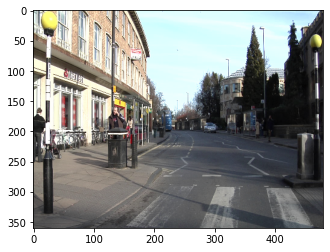

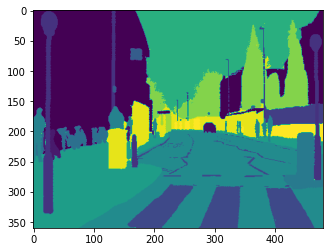

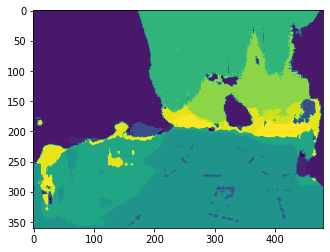

In [ ]:
plt.imshow(img1.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(label1.cpu())
plt.show()
plt.imshow(out1.cpu())
plt.show()

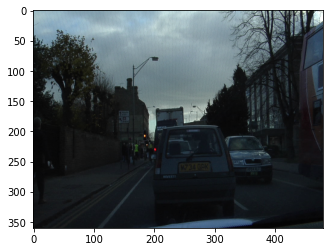

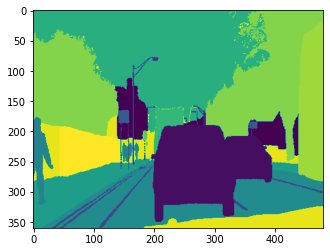

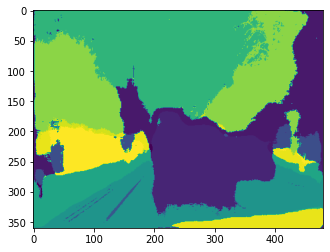

In [ ]:
plt.imshow(img2.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(label2.cpu())
plt.show()
plt.imshow(out2.cpu())
plt.show()

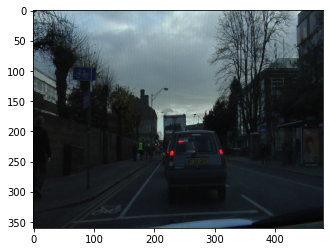

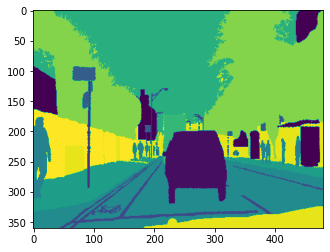

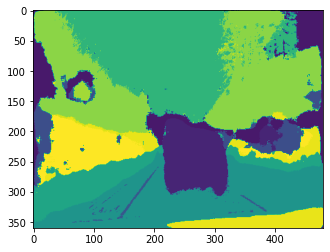

In [ ]:
plt.imshow(img3.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(label3.cpu())
plt.show()
plt.imshow(out3.cpu())
plt.show()

## Trained network with batch normalization

In [ ]:
torch.manual_seed(10)

PATH = '/content/drive/My Drive/SegNet_BN.pth' 
net_test2 = SegNet_BN()
net_test2.load_state_dict(torch.load(PATH))
net_test2.to(device)

In [ ]:
torch.manual_seed(10)

counter = 0

with torch.set_grad_enabled(False):
        for batch_data, batch_labels in test_loader:
            counter += 1
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            batch_outputs = net_test2(batch_data)            
            
            if counter == 1:
              sample_batch_data = batch_data
              sample_batch_labels = batch_labels
              sample_batch_outputs = batch_outputs

In [ ]:
img1 = sample_batch_data[0]
label1 = sample_batch_labels[0]
out1 = torch.argmax(sample_batch_outputs[0], dim = 0)

img2 = sample_batch_data[1]
label2 = sample_batch_labels[1]
out2 = torch.argmax(sample_batch_outputs[1], dim = 0)

img3 = sample_batch_data[2]
label3 = sample_batch_labels[2]
out3 = torch.argmax(sample_batch_outputs[2], dim = 0)

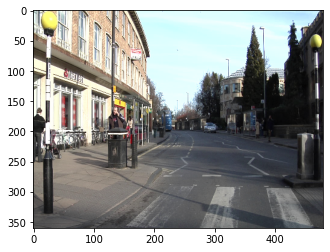

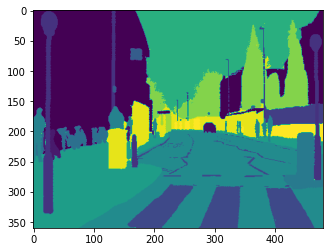

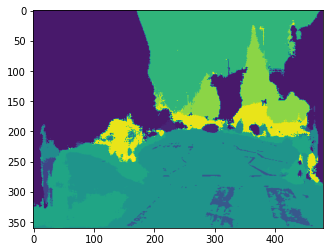

In [ ]:
plt.imshow(img1.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(label1.cpu())
plt.show()
plt.imshow(out1.cpu())
plt.show()

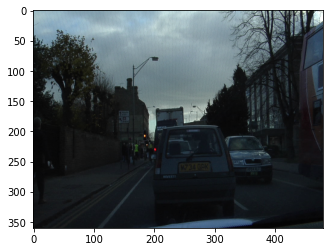

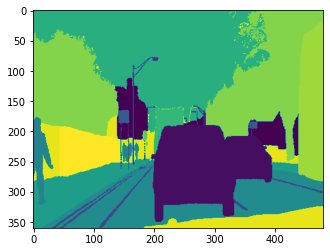

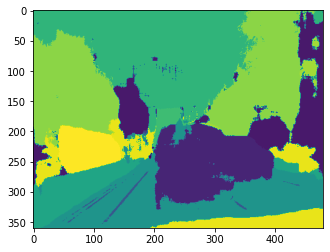

In [ ]:
plt.imshow(img2.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(label2.cpu())
plt.show()
plt.imshow(out2.cpu())
plt.show()

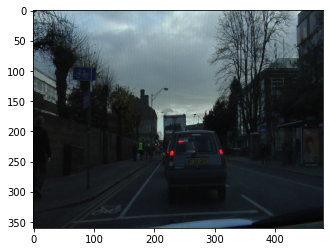

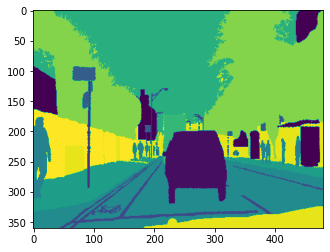

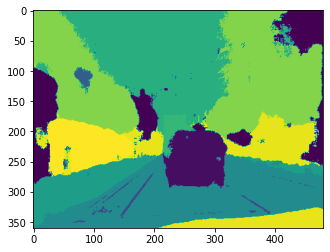

In [ ]:
plt.imshow(img3.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(label3.cpu())
plt.show()
plt.imshow(out3.cpu())
plt.show()